# VIF Critic Model Comparison: MLP vs TCN vs BNN

This notebook provides an **apples-to-apples comparison** between three critic architectures by training and evaluating all on the **exact same dataset**.

**Models:**
1. **CriticMLP** — Baseline 2-layer MLP with MC Dropout
2. **CriticTCN** — Temporal Convolutional Network with MC Dropout
3. **CriticBNN** — Bayesian Neural Network with variational inference

**Contents:**
1. Setup & Data Loading
2. Model Definitions
3. Training Infrastructure
4. Train MLP
5. Train TCN
6. Train BNN
7. Side-by-Side Evaluation
8. Analysis & Conclusions

In [1]:
# Setup
import os
import sys
from pathlib import Path

# Change to project root
notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    os.chdir(notebook_dir.parent)
sys.path.insert(0, ".")

import numpy as np
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Device selection
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Working directory: {os.getcwd()}")
print(f"Using device: {device}")
print(f"Random seed: {SEED}")

Working directory: /Users/desmondchoy/Projects/twinkl
Using device: mps
Random seed: 42


## 1. Data Loading

Load the current dataset and create identical train/val/test splits for both models.

In [2]:
from src.vif.dataset import load_all_data, split_by_persona, VIFDataset
from src.vif.encoders import SBERTEncoder
from src.vif.state_encoder import StateEncoder
from src.models.judge import SCHWARTZ_VALUE_ORDER

# Load raw data
labels_df, entries_df = load_all_data()

print(f"Labels: {labels_df.shape}")
print(f"Entries: {entries_df.shape}")
print(f"Unique personas: {labels_df.select('persona_id').n_unique()}")

# Split by persona (same seed = same split for both models)
train_df, val_df, test_df = split_by_persona(labels_df, entries_df, seed=SEED)

print(f"\nData Split:")
print(
    f"  Train: {len(train_df)} entries ({train_df.select('persona_id').n_unique()} personas)"
)
print(
    f"  Val:   {len(val_df)} entries ({val_df.select('persona_id').n_unique()} personas)"
)
print(
    f"  Test:  {len(test_df)} entries ({test_df.select('persona_id').n_unique()} personas)"
)

Labels: (740, 15)
Entries: (729, 8)
Unique personas: 102

Data Split:
  Train: 498 entries (71 personas)
  Val:   95 entries (14 personas)
  Test:  136 entries (16 personas)


In [3]:
# Create shared encoder (same for both models)
WINDOW_SIZE = 3
EMA_ALPHA = 0.3
BATCH_SIZE = 16

text_encoder = SBERTEncoder("all-MiniLM-L6-v2")
state_encoder = StateEncoder(text_encoder, window_size=WINDOW_SIZE, ema_alpha=EMA_ALPHA)

print(f"Encoder: {text_encoder.model_name}")
print(f"Embedding dim: {text_encoder.embedding_dim}")
print(f"State dim: {state_encoder.state_dim}")
print(f"Window size: {WINDOW_SIZE}")

/Users/desmondchoy/Projects/twinkl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoder: all-MiniLM-L6-v2
Embedding dim: 384
State dim: 1174
Window size: 3


In [4]:
# Create datasets (embeddings cached and shared)
print("Creating datasets (this caches embeddings)...")
train_dataset = VIFDataset(train_df, state_encoder, cache_embeddings=True)
val_dataset = VIFDataset(val_df, state_encoder, cache_embeddings=True)
test_dataset = VIFDataset(test_df, state_encoder, cache_embeddings=True)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Creating datasets (this caches embeddings)...


Batches: 100%|██████████| 5/5 [00:00<00:00, 108.16it/s]

Train batches: 32
Val batches: 6
Test batches: 9


## 2. Model Definitions

Define all three architectures. CriticMLP and CriticBNN are imported from src/vif, CriticTCN is defined here.

In [5]:
from src.vif.critic import CriticMLP

# TCN requires pytorch-tcn package
try:
    from pytorch_tcn import TCN

    TCN_AVAILABLE = True
except ImportError:
    print("WARNING: pytorch-tcn not installed. Run: uv add pytorch-tcn")
    TCN_AVAILABLE = False

# BNN requires bayesian-torch package
try:
    from src.vif.critic_bnn import CriticBNN, get_kl_loss

    BNN_AVAILABLE = True
except ImportError:
    print("WARNING: bayesian-torch not installed. Run: uv add bayesian-torch")
    BNN_AVAILABLE = False


class CriticTCN(nn.Module):
    """TCN critic over a short embedding window.

    Processes text embeddings through temporal convolutions, then concatenates
    non-text features and predicts alignment scores.
    """

    def __init__(
        self,
        *,
        window_size: int,
        embedding_dim: int,
        num_values: int = 10,
        tcn_num_channels: list[int] = [64, 64, 64],
        tcn_kernel_size: int = 3,
        tcn_dropout: float = 0.1,
        head_hidden_dim: int = 128,
        head_dropout: float = 0.2,
        output_dim: int = 10,
    ):
        super().__init__()

        self.window_size = window_size
        self.embedding_dim = embedding_dim
        self.num_values = num_values
        self.output_dim = output_dim

        # Non-text dims: time_gaps + history + profile
        self.nontext_dim = (window_size - 1) + num_values + num_values

        self.tcn = TCN(
            num_inputs=embedding_dim,
            num_channels=tcn_num_channels,
            kernel_size=tcn_kernel_size,
            dropout=tcn_dropout,
            causal=True,
            use_norm="weight_norm",
            activation="relu",
            input_shape="NCL",
        )

        tcn_out_dim = tcn_num_channels[-1]
        head_in_dim = tcn_out_dim + self.nontext_dim

        self.head = nn.Sequential(
            nn.Linear(head_in_dim, head_hidden_dim),
            nn.LayerNorm(head_hidden_dim),
            nn.GELU(),
            nn.Dropout(head_dropout),
        )
        self.out = nn.Linear(head_hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def _split_state(self, x: torch.Tensor):
        text_flat_dim = self.window_size * self.embedding_dim
        text_flat = x[:, :text_flat_dim]
        nontext = x[:, text_flat_dim : text_flat_dim + self.nontext_dim]
        return text_flat, nontext

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        text_flat, nontext = self._split_state(x)

        # Reshape: (N, window*emb) -> (N, emb, window) for TCN
        text_seq = text_flat.view(-1, self.window_size, self.embedding_dim).permute(
            0, 2, 1
        )

        # TCN output: (N, C_out, L) -> take last timestep
        tcn_out = self.tcn(text_seq)
        h = tcn_out[:, :, -1]

        # Concat non-text features and predict
        features = torch.cat([h, nontext], dim=1)
        h2 = self.head(features)
        return self.tanh(self.out(h2))

    def enable_dropout(self):
        """Enable dropout for MC Dropout inference."""
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.train()

    def predict_with_uncertainty(self, x: torch.Tensor, n_samples: int = 50):
        """MC Dropout uncertainty estimation."""
        self.enable_dropout()
        samples = []
        with torch.no_grad():
            for _ in range(n_samples):
                samples.append(self.forward(x))
        samples = torch.stack(samples, dim=0)
        return samples.mean(dim=0), samples.std(dim=0)


print("Model classes defined.")
print(f"TCN available: {TCN_AVAILABLE}")
print(f"BNN available: {BNN_AVAILABLE}")

Model classes defined.
TCN available: True
BNN available: True


## 3. Training Infrastructure

Shared training function to ensure identical training procedure for both models.

In [ ]:
def train_model(
    model,
    train_loader,
    val_loader,
    *,
    n_epochs: int = 100,
    lr: float = 0.001,
    weight_decay: float = 0.01,
    early_stop_patience: int = 20,
    device: str = "cpu",
    verbose: bool = True,
    use_kl_loss: bool = False,  # For BNN training
):
    """Train a model with early stopping.

    Args:
        use_kl_loss: If True, adds KL divergence loss for BNN training.

    Returns:
        dict with best_model_state, best_val_loss, and history
    """
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=10, min_lr=1e-5
    )

    history = {"train_loss": [], "val_loss": [], "lr": []}
    best_val_loss = float("inf")
    best_model_state = None
    patience_counter = 0

    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0.0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)

            optimizer.zero_grad()
            pred = model(batch_x)
            mse_loss = criterion(pred, batch_y)

            # Add KL divergence for BNN
            if use_kl_loss:
                kl_loss = get_kl_loss(model)
                loss = mse_loss + kl_loss / batch_x.size(0)
            else:
                loss = mse_loss

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss /= len(train_loader)

        # Validate (MSE only, no KL)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                pred = model(batch_x)
                val_loss += criterion(pred, batch_y).item()
        val_loss /= len(val_loader)

        # Update scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]["lr"]

        # Record history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["lr"].append(current_lr)

        # Early stopping check
        if val_loss < best_val_loss - 0.001:
            best_val_loss = val_loss
            best_model_state = {
                k: v.cpu().clone() for k, v in model.state_dict().items()
            }
            patience_counter = 0
            if verbose:
                print(
                    f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f} [BEST]"
                )
        else:
            patience_counter += 1
            if verbose and epoch % 10 == 0:
                print(
                    f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f}"
                )

        if patience_counter >= early_stop_patience:
            if verbose:
                print(f"Early stopping at epoch {epoch + 1}")
            break

    return {
        "best_model_state": best_model_state,
        "best_val_loss": best_val_loss,
        "history": history,
        "epochs_trained": epoch + 1,
    }


print("Training function defined.")

Training function defined.


## 4. Train MLP

In [7]:
# MLP hyperparameters (from existing notebook)
MLP_HIDDEN_DIM = 256
MLP_DROPOUT = 0.2

mlp_model = CriticMLP(
    input_dim=state_encoder.state_dim,
    hidden_dim=MLP_HIDDEN_DIM,
    dropout=MLP_DROPOUT,
)

mlp_params = sum(p.numel() for p in mlp_model.parameters())
print(f"MLP parameters: {mlp_params:,}")
print(f"\nTraining MLP...")

mlp_result = train_model(
    mlp_model,
    train_loader,
    val_loader,
    device=device,
)

print(f"\nMLP best val loss: {mlp_result['best_val_loss']:.4f}")
print(f"MLP epochs trained: {mlp_result['epochs_trained']}")

MLP parameters: 370,186

Training MLP...
Epoch   1: train=0.3359, val=0.2924, lr=0.001000 [BEST]
Epoch   2: train=0.2832, val=0.2745, lr=0.001000 [BEST]
Epoch   3: train=0.2648, val=0.2662, lr=0.001000 [BEST]
Epoch   4: train=0.2518, val=0.2591, lr=0.001000 [BEST]
Epoch  11: train=0.2378, val=0.2644, lr=0.001000
Epoch  12: train=0.2357, val=0.2578, lr=0.001000 [BEST]
Epoch  21: train=0.2218, val=0.2726, lr=0.001000
Epoch  31: train=0.2099, val=0.2623, lr=0.000500
Early stopping at epoch 32

MLP best val loss: 0.2578
MLP epochs trained: 32


## 5. Train TCN

In [8]:
if not TCN_AVAILABLE:
    print("Skipping TCN training - pytorch-tcn not installed")
    tcn_result = None
else:
    # TCN hyperparameters
    # TODO(human): Choose TCN channel width to test capacity hypothesis
    TCN_NUM_CHANNELS = [64, 64, 64]  # Original from PR
    # TCN_NUM_CHANNELS = [256, 256]  # Match MLP capacity
    TCN_KERNEL_SIZE = 3
    TCN_DROPOUT = 0.1
    TCN_HEAD_HIDDEN = 128
    TCN_HEAD_DROPOUT = 0.2

    tcn_model = CriticTCN(
        window_size=WINDOW_SIZE,
        embedding_dim=text_encoder.embedding_dim,
        tcn_num_channels=TCN_NUM_CHANNELS,
        tcn_kernel_size=TCN_KERNEL_SIZE,
        tcn_dropout=TCN_DROPOUT,
        head_hidden_dim=TCN_HEAD_HIDDEN,
        head_dropout=TCN_HEAD_DROPOUT,
    )

    tcn_params = sum(p.numel() for p in tcn_model.parameters())
    print(f"TCN parameters: {tcn_params:,}")
    print(f"TCN channels: {TCN_NUM_CHANNELS}")
    print(f"\nTraining TCN...")

    tcn_result = train_model(
        tcn_model,
        train_loader,
        val_loader,
        device=device,
    )

    print(f"\nTCN best val loss: {tcn_result['best_val_loss']:.4f}")
    print(f"TCN epochs trained: {tcn_result['epochs_trained']}")

TCN parameters: 173,258
TCN channels: [64, 64, 64]

Training TCN...
Epoch   1: train=0.3206, val=0.2723, lr=0.001000 [BEST]
Epoch   2: train=0.2622, val=0.2611, lr=0.001000 [BEST]
Epoch  11: train=0.2274, val=0.2650, lr=0.001000
Epoch  14: train=0.2243, val=0.2599, lr=0.001000 [BEST]
Epoch  21: train=0.2087, val=0.2670, lr=0.001000
Epoch  31: train=0.2003, val=0.2841, lr=0.000500
Early stopping at epoch 34

TCN best val loss: 0.2599
TCN epochs trained: 34


## 6. Train BNN

In [9]:
if not BNN_AVAILABLE:
    print("Skipping BNN training - bayesian-torch not installed")
    bnn_result = None
else:
    # BNN hyperparameters (match MLP capacity)
    BNN_HIDDEN_DIM = 256

    bnn_model = CriticBNN(
        input_dim=state_encoder.state_dim,
        hidden_dim=BNN_HIDDEN_DIM,
    )

    bnn_params = sum(p.numel() for p in bnn_model.parameters())
    print(f"BNN parameters: {bnn_params:,}")
    print(f"\nTraining BNN (with KL loss)...")

    bnn_result = train_model(
        bnn_model,
        train_loader,
        val_loader,
        device=device,
        use_kl_loss=True,  # Key difference: adds KL divergence
    )

    print(f"\nBNN best val loss: {bnn_result['best_val_loss']:.4f}")
    print(f"BNN epochs trained: {bnn_result['epochs_trained']}")

BNN parameters: 739,348

Training BNN (with KL loss)...
Epoch   1: train=1.7143, val=0.5023, lr=0.001000 [BEST]
Epoch   2: train=1.6061, val=0.4836, lr=0.001000 [BEST]
Epoch   3: train=1.5476, val=0.4280, lr=0.001000 [BEST]
Epoch   4: train=1.5051, val=0.3570, lr=0.001000 [BEST]
Epoch   7: train=1.4256, val=0.3361, lr=0.001000 [BEST]
Epoch   8: train=1.4185, val=0.3015, lr=0.001000 [BEST]
Epoch  11: train=1.3761, val=0.2821, lr=0.001000 [BEST]
Epoch  16: train=1.3395, val=0.2781, lr=0.001000 [BEST]
Epoch  21: train=1.3150, val=0.2872, lr=0.001000
Epoch  31: train=1.2591, val=0.2808, lr=0.000500
Epoch  34: train=1.2488, val=0.2758, lr=0.000500 [BEST]
Epoch  35: train=1.2465, val=0.2714, lr=0.000500 [BEST]
Epoch  41: train=1.2306, val=0.2720, lr=0.000500
Epoch  51: train=1.2031, val=0.2835, lr=0.000250
Early stopping at epoch 55

BNN best val loss: 0.2714
BNN epochs trained: 55


## 7. Side-by-Side Evaluation

In [10]:
from src.vif.eval import evaluate_with_uncertainty, format_results_table

N_MC_SAMPLES = 50

# Evaluate MLP
mlp_model.load_state_dict(mlp_result["best_model_state"])
mlp_model.to(device)
print("Evaluating MLP on test set...")
mlp_results = evaluate_with_uncertainty(
    mlp_model, test_loader, n_mc_samples=N_MC_SAMPLES, device=device
)

# Evaluate TCN
if tcn_result is not None:
    tcn_model.load_state_dict(tcn_result["best_model_state"])
    tcn_model.to(device)
    print("Evaluating TCN on test set...")
    tcn_results = evaluate_with_uncertainty(
        tcn_model, test_loader, n_mc_samples=N_MC_SAMPLES, device=device
    )
else:
    tcn_results = None

# Evaluate BNN
if bnn_result is not None:
    bnn_model.load_state_dict(bnn_result["best_model_state"])
    bnn_model.to(device)
    print("Evaluating BNN on test set...")
    bnn_results = evaluate_with_uncertainty(
        bnn_model, test_loader, n_mc_samples=N_MC_SAMPLES, device=device
    )
else:
    bnn_results = None

Evaluating MLP on test set...
Evaluating TCN on test set...
Evaluating BNN on test set...


In [11]:
print("=" * 70)
print("MLP RESULTS")
print("=" * 70)
print(format_results_table(mlp_results))

MLP RESULTS
Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3646      0.366     53.68%
stimulation              0.1264      0.536     88.97%
hedonism                 0.1615      0.280     84.56%
achievement              0.3318      0.542     65.44%
power                    0.1687      0.458     79.41%
security                 0.2778      0.349     67.65%
conformity               0.1864      0.504     79.41%
tradition                0.2331      0.375     72.06%
benevolence              0.3871      0.315     57.35%
universalism             0.1074      0.435     85.29%
----------------------------------------------------------------------
MEAN                     0.2345      0.416     73.38%

Calibration:
  Error-uncertainty correlation: 0.090
  Mean uncertainty: 0.0725


In [12]:
if tcn_results is not None:
    print("=" * 70)
    print("TCN RESULTS")
    print("=" * 70)
    print(format_results_table(tcn_results))
else:
    print("TCN results not available (pytorch-tcn not installed)")

TCN RESULTS
Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3580      0.387     63.24%
stimulation              0.1167      0.523     87.50%
hedonism                 0.1675      0.350     85.29%
achievement              0.3181      0.504     61.03%
power                    0.1650      0.405     80.15%
security                 0.2784      0.337     66.91%
conformity               0.1784      0.480     79.41%
tradition                0.2304      0.368     73.53%
benevolence              0.3795      0.321     58.09%
universalism             0.1014      0.385     89.71%
----------------------------------------------------------------------
MEAN                     0.2293      0.406     74.49%

Calibration:
  Error-uncertainty correlation: 0.025
  Mean uncertainty: 0.0778


In [13]:
if bnn_results is not None:
    print("=" * 70)
    print("BNN RESULTS")
    print("=" * 70)
    print(format_results_table(bnn_results))
else:
    print("BNN results not available (bayesian-torch not installed)")

BNN RESULTS
Dimension                   MSE   Spearman   Accuracy
----------------------------------------------------------------------
self_direction           0.3414      0.413     58.82%
stimulation              0.1291      0.535     85.29%
hedonism                 0.1701      0.352     84.56%
achievement              0.3064      0.562     64.71%
power                    0.1694      0.423     79.41%
security                 0.2742      0.338     68.38%
conformity               0.1727      0.513     80.15%
tradition                0.2258      0.394     72.06%
benevolence              0.3969      0.311     58.09%
universalism             0.1055      0.447     85.29%
----------------------------------------------------------------------
MEAN                     0.2292      0.429     73.68%

Calibration:
  Error-uncertainty correlation: -0.348
  Mean uncertainty: 0.1506


In [14]:
# Side-by-side comparison table
print("\n" + "=" * 90)
print("SIDE-BY-SIDE COMPARISON")
print("=" * 90)

print(f"{'Metric':<30} {'MLP':>15} {'TCN':>15} {'BNN':>15} {'Winner':>12}")
print("-" * 90)


def get_winner(*values_and_names, higher_is_better=True):
    """Determine winner from (value, name) pairs, handling None values."""
    valid = [(v, n) for v, n in values_and_names if v is not None]
    if not valid:
        return "N/A"
    if higher_is_better:
        return max(valid, key=lambda x: x[0])[1]
    else:
        return min(valid, key=lambda x: x[0])[1]


metrics = [
    (
        "Parameters",
        f"{mlp_params:,}",
        f"{tcn_params:,}" if tcn_result else "N/A",
        f"{bnn_params:,}" if bnn_result else "N/A",
        get_winner(
            (mlp_params, "MLP"),
            (tcn_params if tcn_result else None, "TCN"),
            (bnn_params if bnn_result else None, "BNN"),
            higher_is_better=False,
        ),
    ),
    (
        "Best Val Loss",
        f"{mlp_result['best_val_loss']:.4f}",
        f"{tcn_result['best_val_loss']:.4f}" if tcn_result else "N/A",
        f"{bnn_result['best_val_loss']:.4f}" if bnn_result else "N/A",
        get_winner(
            (mlp_result["best_val_loss"], "MLP"),
            (tcn_result["best_val_loss"] if tcn_result else None, "TCN"),
            (bnn_result["best_val_loss"] if bnn_result else None, "BNN"),
            higher_is_better=False,
        ),
    ),
    (
        "Test MSE",
        f"{mlp_results['mse_mean']:.4f}",
        f"{tcn_results['mse_mean']:.4f}" if tcn_results else "N/A",
        f"{bnn_results['mse_mean']:.4f}" if bnn_results else "N/A",
        get_winner(
            (mlp_results["mse_mean"], "MLP"),
            (tcn_results["mse_mean"] if tcn_results else None, "TCN"),
            (bnn_results["mse_mean"] if bnn_results else None, "BNN"),
            higher_is_better=False,
        ),
    ),
    (
        "Test Spearman",
        f"{mlp_results['spearman_mean']:.4f}",
        f"{tcn_results['spearman_mean']:.4f}" if tcn_results else "N/A",
        f"{bnn_results['spearman_mean']:.4f}" if bnn_results else "N/A",
        get_winner(
            (mlp_results["spearman_mean"], "MLP"),
            (tcn_results["spearman_mean"] if tcn_results else None, "TCN"),
            (bnn_results["spearman_mean"] if bnn_results else None, "BNN"),
            higher_is_better=True,
        ),
    ),
    (
        "Test Accuracy",
        f"{mlp_results['accuracy_mean']:.2%}",
        f"{tcn_results['accuracy_mean']:.2%}" if tcn_results else "N/A",
        f"{bnn_results['accuracy_mean']:.2%}" if bnn_results else "N/A",
        get_winner(
            (mlp_results["accuracy_mean"], "MLP"),
            (tcn_results["accuracy_mean"] if tcn_results else None, "TCN"),
            (bnn_results["accuracy_mean"] if bnn_results else None, "BNN"),
            higher_is_better=True,
        ),
    ),
    (
        "Error-Uncertainty Corr",
        f"{mlp_results['calibration']['error_uncertainty_correlation']:.3f}",
        f"{tcn_results['calibration']['error_uncertainty_correlation']:.3f}"
        if tcn_results
        else "N/A",
        f"{bnn_results['calibration']['error_uncertainty_correlation']:.3f}"
        if bnn_results
        else "N/A",
        get_winner(
            (mlp_results["calibration"]["error_uncertainty_correlation"], "MLP"),
            (
                tcn_results["calibration"]["error_uncertainty_correlation"]
                if tcn_results
                else None,
                "TCN",
            ),
            (
                bnn_results["calibration"]["error_uncertainty_correlation"]
                if bnn_results
                else None,
                "BNN",
            ),
            higher_is_better=True,
        ),
    ),
]

for metric, mlp_val, tcn_val, bnn_val, winner in metrics:
    print(f"{metric:<30} {mlp_val:>15} {tcn_val:>15} {bnn_val:>15} {winner:>12}")

print("=" * 90)


SIDE-BY-SIDE COMPARISON
Metric                                     MLP             TCN             BNN       Winner
------------------------------------------------------------------------------------------
Parameters                             370,186         173,258         739,348          TCN
Best Val Loss                           0.2578          0.2599          0.2714          MLP
Test MSE                                0.2345          0.2293          0.2292          BNN
Test Spearman                           0.4160          0.4061          0.4287          BNN
Test Accuracy                           73.38%          74.49%          73.68%          TCN
Error-Uncertainty Corr                   0.090           0.025          -0.348          MLP


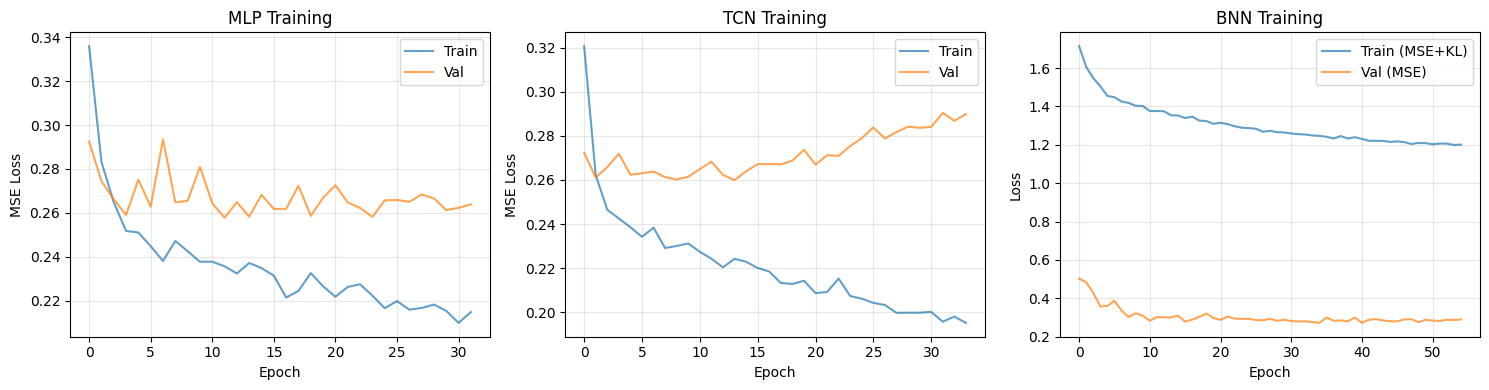

In [15]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# MLP curves
axes[0].plot(mlp_result["history"]["train_loss"], label="Train", alpha=0.7)
axes[0].plot(mlp_result["history"]["val_loss"], label="Val", alpha=0.7)
axes[0].set_title("MLP Training")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("MSE Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# TCN curves
if tcn_result:
    axes[1].plot(tcn_result["history"]["train_loss"], label="Train", alpha=0.7)
    axes[1].plot(tcn_result["history"]["val_loss"], label="Val", alpha=0.7)
    axes[1].set_title("TCN Training")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("MSE Loss")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, "TCN not available", ha="center", va="center")
    axes[1].set_title("TCN Training")

# BNN curves
if bnn_result:
    axes[2].plot(bnn_result["history"]["train_loss"], label="Train (MSE+KL)", alpha=0.7)
    axes[2].plot(bnn_result["history"]["val_loss"], label="Val (MSE)", alpha=0.7)
    axes[2].set_title("BNN Training")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Loss")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, "BNN not available", ha="center", va="center")
    axes[2].set_title("BNN Training")

plt.tight_layout()
plt.show()

## 8. Analysis & Conclusions

After running this notebook, consider:

1. **Which model performs better on the same data?**
2. **Is the performance gap due to capacity?** Try changing `TCN_NUM_CHANNELS` to `[256, 256]` to match MLP width.
3. **Is calibration (error-uncertainty correlation) positive?** Positive correlation means the model knows when it's uncertain.
4. **Does BNN's principled uncertainty estimation beat MC Dropout?** Compare calibration between MLP (MC Dropout) and BNN (variational inference).
5. **Is the temporal inductive bias helping?** With `window_size=3`, does the TCN's sequential processing add value?

In [16]:
# Final summary
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY")
print("=" * 70)
print(
    f"Dataset: {len(train_df)} train / {len(val_df)} val / {len(test_df)} test entries"
)
print(
    f"Personas: {train_df.select('persona_id').n_unique()} train / {val_df.select('persona_id').n_unique()} val / {test_df.select('persona_id').n_unique()} test"
)
print(f"Encoder: {text_encoder.model_name}")
print(f"Window size: {WINDOW_SIZE}")
print(f"Random seed: {SEED}")
print()
print(
    f"MLP: {mlp_params:,} params, val_loss={mlp_result['best_val_loss']:.4f}, test_mse={mlp_results['mse_mean']:.4f}, calib={mlp_results['calibration']['error_uncertainty_correlation']:.3f}"
)
if tcn_result and tcn_results:
    print(
        f"TCN: {tcn_params:,} params, val_loss={tcn_result['best_val_loss']:.4f}, test_mse={tcn_results['mse_mean']:.4f}, calib={tcn_results['calibration']['error_uncertainty_correlation']:.3f}"
    )
if bnn_result and bnn_results:
    print(
        f"BNN: {bnn_params:,} params, val_loss={bnn_result['best_val_loss']:.4f}, test_mse={bnn_results['mse_mean']:.4f}, calib={bnn_results['calibration']['error_uncertainty_correlation']:.3f}"
    )
print("=" * 70)


EXPERIMENT SUMMARY
Dataset: 498 train / 95 val / 136 test entries
Personas: 71 train / 14 val / 16 test
Encoder: all-MiniLM-L6-v2
Window size: 3
Random seed: 42

MLP: 370,186 params, val_loss=0.2578, test_mse=0.2345, calib=0.090
TCN: 173,258 params, val_loss=0.2599, test_mse=0.2293, calib=0.025
BNN: 739,348 params, val_loss=0.2714, test_mse=0.2292, calib=-0.348
